# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
+ DateCrawled — дата скачивания анкеты из базы
+ VehicleType — тип автомобильного кузова
+ RegistrationYear — год регистрации автомобиля
+ Gearbox — тип коробки передач
+ Power — мощность (л. с.)
+ Model — модель автомобиля
+ Kilometer — пробег (км)
+ RegistrationMonth — месяц регистрации автомобиля
+ FuelType — тип топлива
+ Brand — марка автомобиля
+ Repaired — была машина в ремонте или нет
+ DateCreated — дата создания анкеты
+ NumberOfPictures — количество фотографий автомобиля
+ PostalCode — почтовый индекс владельца анкеты (пользователя)
+ LastSeen — дата последней активности пользователя
   
   Целевой признак:
+ Price — цена (евро)

## Подготовка данных

In [1]:
#!pip install pandas-profiling
import pandas_profiling
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from math import sqrt
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder

/tmp/ipykernel_319/4050108477.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [2]:
#сохраним наши данные в переменную data
data = pd.read_csv("/datasets/autos.csv")

display(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
profile = pandas_profiling.ProfileReport(data)
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [1]:
profile


NameError: name 'profile' is not defined

In [5]:
#проверим на не явные дубликаты
print(data['Model'].unique())
print(data['Brand'].unique())
print(data['VehicleType'].unique())
print(data['Gearbox'].unique())
print(data['Repaired'].unique())

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

Все уникальные значения записаны корректно.

### Проверим наш датафрейм кол-во пропусков

In [6]:
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Значение в столбце Repaired заполним 'Unknown'

In [7]:
data['Repaired'] = data['Repaired'].fillna('Unknown')
data['Repaired'].isnull().sum()

0

Пропуски в столбце заполнили корректно.

In [8]:
#удалим столбцы , которые нам не понадобяться для обучении модели.
data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'FuelType'], axis = 1, inplace = True)

print(data.head(5))

   Price VehicleType  RegistrationYear Gearbox  Power  Model  Kilometer  \
0    480         NaN              1993  manual      0   golf     150000   
1  18300       coupe              2011  manual    190    NaN     125000   
2   9800         suv              2004    auto    163  grand     125000   
3   1500       small              2001  manual     75   golf     150000   
4   3600       small              2008  manual     69  fabia      90000   

        Brand Repaired  
0  volkswagen  Unknown  
1        audi      yes  
2        jeep  Unknown  
3  volkswagen       no  
4       skoda       no  


In [9]:
# пропуски в столбце Model удалим , так как логически мы не сможем их заполнить.
data = data.dropna (subset=['Model'])
data = data.reset_index(drop=True)
data['Model'].isnull().sum()
display(data)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,volkswagen,Unknown
1,9800,suv,2004,auto,163,grand,125000,jeep,Unknown
2,1500,small,2001,manual,75,golf,150000,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,skoda,no
4,650,sedan,1995,manual,102,3er,150000,bmw,yes
...,...,...,...,...,...,...,...,...,...
334659,1150,bus,2000,manual,0,zafira,150000,opel,no
334660,0,NaN,2005,manual,0,colt,150000,mitsubishi,yes
334661,1199,convertible,2000,auto,101,fortwo,125000,smart,no
334662,9200,bus,1996,manual,102,transporter,150000,volkswagen,no


In [10]:
# проверим , какие пропуски остались в наших данных
data.isnull().sum()


Price                   0
VehicleType         30662
RegistrationYear        0
Gearbox             15702
Power                   0
Model                   0
Kilometer               0
Brand                   0
Repaired                0
dtype: int64

In [11]:
# столбцы VehicleType и Gearbox , заполним значениями 'Unknowm'
data['VehicleType'] = data['VehicleType'].fillna('Unknown')
data['Gearbox'] = data['Gearbox'].fillna('Unknown')
# првоерим ещё раз наши данные на пропуски
data.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
Brand               0
Repaired            0
dtype: int64

Отлично , мы избавились от пропусков

### Проверим данные на наличие дубликатов

In [12]:
data.duplicated().sum()

47476

In [13]:
# избавимся от явных дубликатов
data = data.drop_duplicates()
# проверим 
data.duplicated().sum()

0

От явных дубилкатов мы избавились.На неявные дубликаты мы уже проверили выше , когда смотрели уникальные значения столбцов с названием бренда и модели.

### Проверим на аномалии наши данные.

In [14]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,287188.0000,287188.000000,287188.000000,287188.000000
mean,4606.5210,2004.094774,112.504262,127277.166873
std,4595.8872,74.286838,197.434807,38041.225601
min,0.0000,1000.000000,0.000000,5000.000000
25%,1190.0000,1999.000000,71.000000,125000.000000
50%,2900.0000,2003.000000,105.000000,150000.000000
75%,6700.0000,2008.000000,143.000000,150000.000000
max,20000.0000,9999.000000,20000.000000,150000.000000


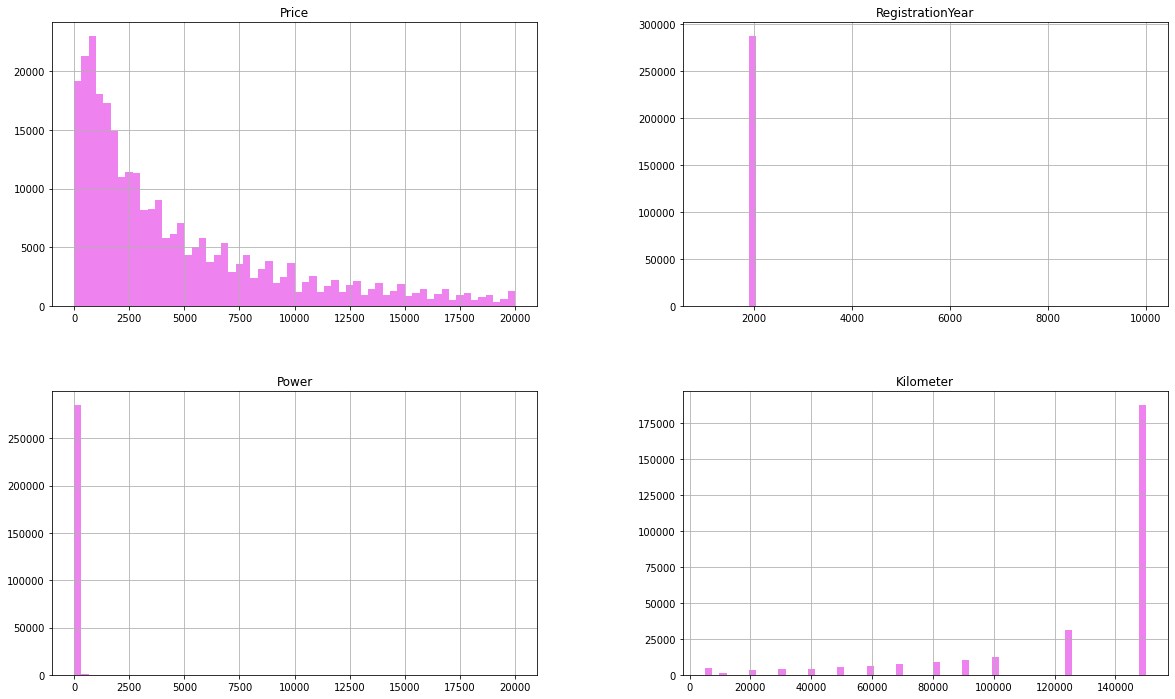

In [15]:
data.hist(bins=60, figsize = (20, 12), color = 'Violet');

,RegistrationYear,Power,Kilometer
RegistrationYear,1.000000,0.001767,-0.052948
Power,0.001767,1.000000,0.025941
Kilometer,-0.052948,0.025941,1.000000


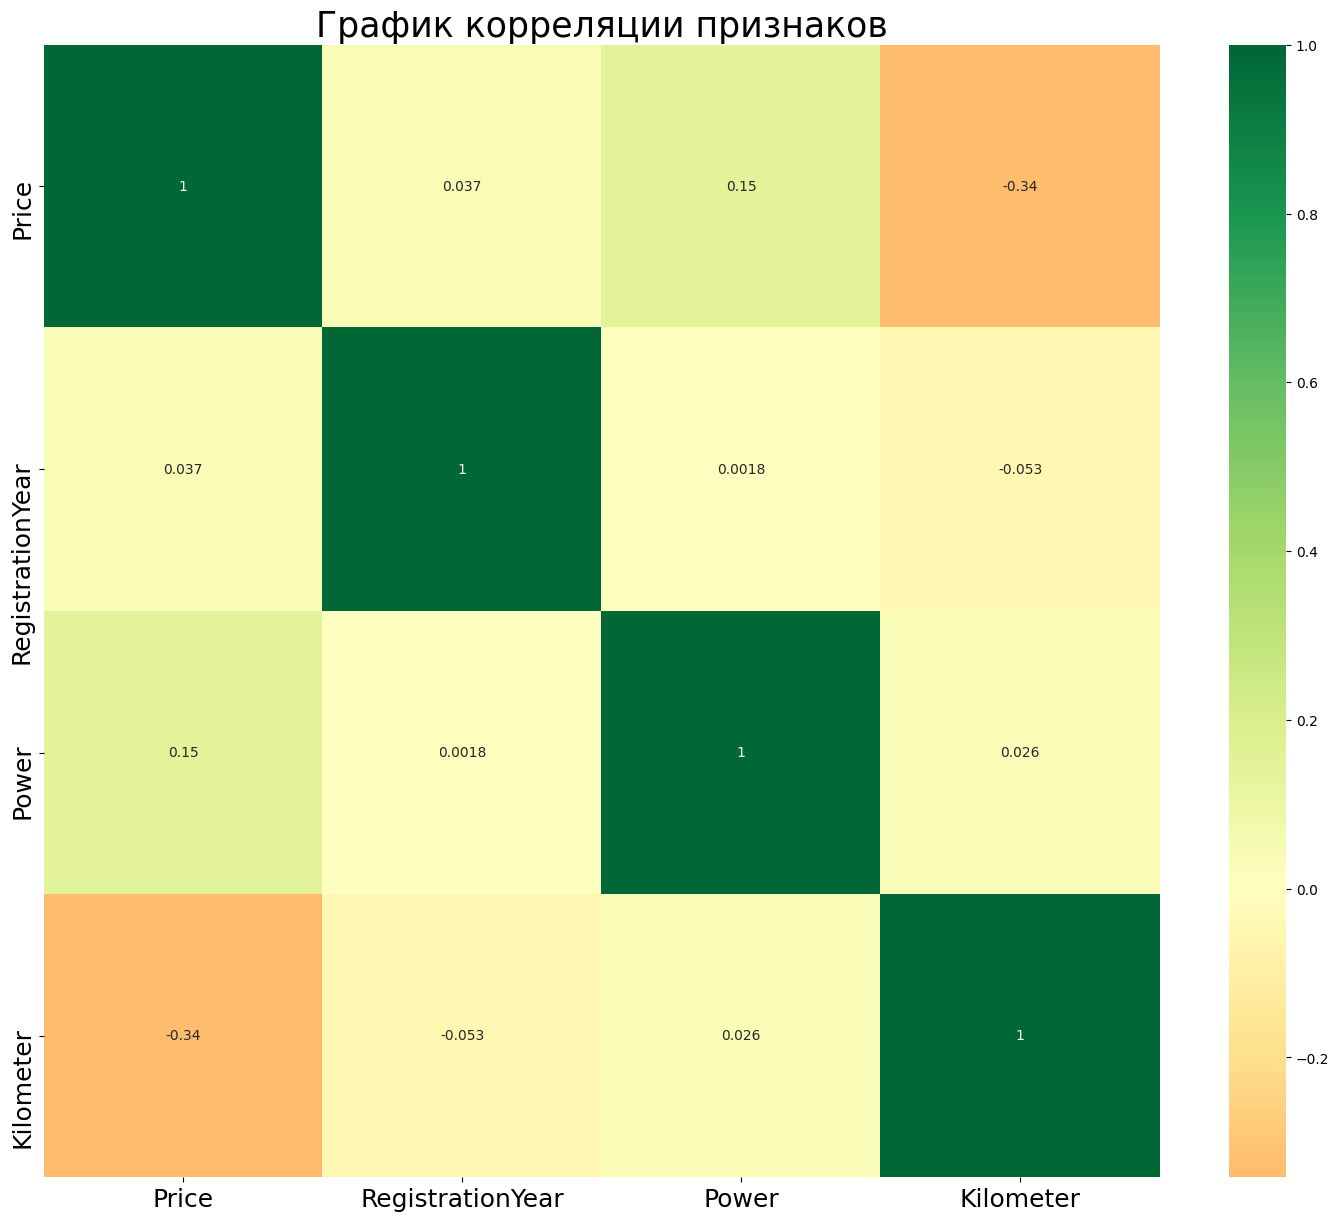

In [16]:
# Рассчитаем корреляцию параметров и проверим мультиколлениарность. Без таргета смотрим.
display(data.drop(['Price'],axis = 1).corr())

#Построим график корреляции параметров
plt.figure(figsize=(18,15), dpi= 100)
sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('График корреляции признаков', fontsize=25)
plt.xticks(fontsize= 18
          )
plt.yticks(fontsize=18)
plt.show()

In [17]:
# оставим значение колонки Price начиная от 250 евро
data = data.loc[(data['Price'] >= 250)]

data.describe()

,Price,RegistrationYear,Power,Kilometer
count,272924.000000,272924.000000,272924.000000,272924.000000
mean,4843.802429,2003.983211,114.490550,127310.130293
std,4592.620441,58.253593,195.109686,37578.227049
min,250.000000,1000.000000,0.000000,5000.000000
25%,1350.000000,1999.000000,75.000000,125000.000000
50%,3150.000000,2004.000000,106.000000,150000.000000
75%,6950.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [18]:
# сделаем диапазон данных RegistrationYear в промежутке 1980 - 2023 г

data = data.loc[(data['RegistrationYear'] >= 1980) & (data['RegistrationYear'] <= 2023)]
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,270673.000000,270673.000000,270673.000000,270673.000000
mean,4820.654945,2003.727483,114.815102,127630.277124
std,4578.644056,6.502752,195.690299,37271.131819
min,250.000000,1980.000000,0.000000,5000.000000
25%,1350.000000,1999.000000,75.000000,125000.000000
50%,3100.000000,2004.000000,107.000000,150000.000000
75%,6900.000000,2008.000000,143.000000,150000.000000
max,20000.000000,2019.000000,20000.000000,150000.000000


In [19]:
# избавимся от оставшихся аномалий в столбце Power 
# значение в столбце оставим в промежутке от 25 до 500
data = data.loc[(data['Power'] >= 25) & (data['Power'] <= 500)]

data.describe()

,Price,RegistrationYear,Power,Kilometer
count,245471.000000,245471.000000,245471.000000,245471.000000
mean,5041.688656,2003.767431,122.211186,127282.978437
std,4640.172000,6.334626,53.048225,37120.616999
min,250.000000,1980.000000,25.000000,5000.000000
25%,1499.000000,1999.000000,82.000000,125000.000000
50%,3400.000000,2004.000000,115.000000,150000.000000
75%,7250.000000,2008.000000,150.000000,150000.000000
max,20000.000000,2019.000000,500.000000,150000.000000


Все аномалии обработаны

### Проверим тип данные 

In [20]:
data.dtypes

Price                int64
VehicleType         object
RegistrationYear     int64
Gearbox             object
Power                int64
Model               object
Kilometer            int64
Brand               object
Repaired            object
dtype: object

In [21]:
# переменные типа object поменяем в категориальные

data['VehicleType'] = data['VehicleType'].astype('category')
data['Gearbox'] = data['Gearbox'].astype('category')
data['Model'] = data['Model'].astype('category')
data['Brand'] = data['Brand'].astype('category')
data['Repaired'] = data['Repaired'].astype('category')


data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245471 entries, 1 to 334663
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Price             245471 non-null  int64   
 1   VehicleType       245471 non-null  category
 2   RegistrationYear  245471 non-null  int64   
 3   Gearbox           245471 non-null  category
 4   Power             245471 non-null  int64   
 5   Model             245471 non-null  category
 6   Kilometer         245471 non-null  int64   
 7   Brand             245471 non-null  category
 8   Repaired          245471 non-null  category
dtypes: category(5), int64(4)
memory usage: 10.8 MB


## Обучение моделей

In [22]:
#Преобразуем столбец Model
encoder = OrdinalEncoder()
encoder.fit(data[['Model']])
data['Model'] = encoder.transform(data[['Model']])

In [23]:
#Преобразуем остальные категории в числа
one_hot_list = ['VehicleType','Gearbox', 'Brand', 'Repaired']
df = data.copy()
tenure_one_hot = pd.get_dummies(df[one_hot_list], drop_first=True)
df = df.drop(one_hot_list,axis = 1)
df = df.join(tenure_one_hot, how='left')
df

,Price,RegistrationYear,Power,Model,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_no,Repaired_yes
1,9800,2004,163,117.0,125000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1500,2001,75,116.0,150000,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,3600,2008,69,101.0,90000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,650,1995,102,11.0,150000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5,2200,2004,109,8.0,150000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334657,5250,2016,150,4.0,150000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
334658,3200,2004,225,140.0,150000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
334661,1199,2000,101,106.0,125000,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
334662,9200,1996,102,222.0,150000,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [24]:
data = data.reset_index(drop=True)

In [25]:
features = df.drop('Price', axis = 1)
target = df['Price']
# Разделим на выборки

#Отделение тестовой части
x, features_test, y, target_test = train_test_split(features, target, test_size=0.2, train_size=0.8)



In [26]:
#Отделения валидационной и обучающей выборки
features_train, features_valid, target_train, target_valid = train_test_split(x, y, test_size = 0.25, train_size =0.75)

In [27]:
#Скалирование
scaler = StandardScaler()
scaler.fit(features_train) 
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

In [28]:
#Преобразуем nparray в dataframe
def nptodf(data, ind, column):
    frame = pd.DataFrame(data, index = ind.index, columns = column.columns)
    return frame
features_train_scaled = nptodf(features_train_scaled, target_train, features)
features_valid_scaled = nptodf(features_valid_scaled, target_valid, features)
features_test_scaled = nptodf(features_test_scaled, target_test, features)

print(features_valid_scaled.shape)
print(target_valid.shape)

print(features_train_scaled.shape)
print(features_test_scaled.shape)
print(target_train.shape)
print(target_test.shape)

(49094, 54)
(49094,)
(147282, 54)
(49095, 54)
(147282,)
(49095,)


### Модель RandomForestRegressor

In [29]:
model_rf = RandomForestRegressor(random_state = 12345)
parametrs = {'n_estimators': range(1,40), 'max_depth': range(1,51)}

In [30]:
%%time
model_rf_cv = RandomizedSearchCV(model_rf, parametrs, cv=5, scoring = 'neg_mean_squared_error', n_iter=1, n_jobs=-1, verbose=1)
model_rf_cv.fit(features_train_scaled, target_train)
predict_rf_cv = model_rf_cv.predict(features_valid_scaled)  # получаем предсказания модели
print("RMSE:", sqrt(mean_squared_error(target_valid, predict_rf_cv)), 'при', model_rf_cv.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
RMSE: 1670.0966554180911 при {'n_estimators': 27, 'max_depth': 36}
CPU times: user 1min 51s, sys: 1.25 s, total: 1min 52s
Wall time: 1min 52s


In [31]:
results_rf = model_rf_cv.cv_results_
best_index_rf = model_rf_cv.best_index_

rf_fit_time = results_rf['mean_fit_time'][best_index_rf]
rf_score_time = results_rf['mean_score_time'][best_index_rf]


print(f"Fit time: {rf_fit_time}, Predict time: {rf_score_time}")

Fit time: 17.548541212081908, Predict time: 0.3525566577911377


### Модель LinearRegression

In [32]:
# обцучим модель без гиперпараметров

In [33]:
model_lr = LinearRegression()
parametrs =  {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}


In [34]:
%%time
model_lr_cv = GridSearchCV(model_lr, parametrs, cv = 5, scoring = 'neg_mean_squared_error')
model_lr_cv.fit(features_train_scaled, target_train)
predict_lr_cv = model_lr_cv.predict(features_valid_scaled)
print("RMSE:", sqrt(mean_squared_error(target_valid, predict_lr_cv)), 'при', model_lr_cv.best_params_)

RMSE: 2626.0140329923715 при {'copy_X': True, 'fit_intercept': True, 'normalize': True}
CPU times: user 35.4 s, sys: 19.7 s, total: 55.1 s
Wall time: 55.1 s


In [35]:
results_rf =  model_lr_cv.cv_results_
best_index_rf =  model_lr_cv.best_index_

lr_fit_time = results_rf['mean_fit_time'][best_index_rf]
lr_score_time = results_rf['mean_score_time'][best_index_rf]


print(f"Fit time: {lr_fit_time}, Predict time: {lr_score_time}")

Fit time: 1.190300178527832, Predict time: 0.09416089057922364


### Модель LightGBM

In [36]:
model_lgbm = LGBMRegressor()
lgbm_params = {"n_estimators": [1000, 1200],
               "max_depth": [12, 14]
              }

In [37]:
%%time
model_lgbm_cv = GridSearchCV(model_lgbm, lgbm_params, cv = 5, scoring = 'neg_mean_squared_error')
model_lgbm_cv.fit(features_train_scaled, target_train)
predict_lgbm_cv = model_lgbm_cv.predict(features_valid_scaled)
print('RMSE:', sqrt(mean_squared_error(target_valid, predict_lgbm_cv)), 'при', model_lgbm_cv.best_params_)

RMSE: 1552.1666147491749 при {'max_depth': 14, 'n_estimators': 1200}
CPU times: user 19min 29s, sys: 6.1 s, total: 19min 35s
Wall time: 19min 42s


In [38]:
results_rf =  model_lgbm_cv.cv_results_
best_index_rf =  model_lgbm_cv.best_index_

lgbm_fit_time = results_rf['mean_fit_time'][best_index_rf]
lgbm_score_time = results_rf['mean_score_time'][best_index_rf]


print(f"Fit time: {lgbm_fit_time}, Predict time: {lgbm_score_time}")

Fit time: 119.98653321266174, Predict time: 3.676374673843384


## Анализ моделей

In [39]:
# создадим ДатаФрейм со всеми результатами.

result = {'Model' : ['RandomForestRegressor', 'LinearRegression', 'LightGBM'],
          'Parametrs' : [model_rf_cv.best_params_, model_lr_cv.best_params_, model_lgbm_cv.best_params_],
          'RMSE' : [sqrt(mean_squared_error(target_valid, predict_rf_cv)), sqrt(mean_squared_error(target_valid, predict_lr_cv)), 
                    sqrt(mean_squared_error(target_valid, predict_lgbm_cv))],
          'Fit time: ': [rf_fit_time , lr_fit_time , lgbm_fit_time],
          'Predict time': [rf_score_time, lr_score_time,lgbm_score_time]
          
    
}
final_result = pd.DataFrame(result)

display(final_result)

,Model,Parametrs,RMSE,Fit time:,Predict time
0,RandomForestRegressor,"{'n_estimators': 27, 'max_depth': 36}",1670.096655,17.548541,0.352557
1,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'norma...",2626.014033,1.190300,0.094161
2,LightGBM,"{'max_depth': 14, 'n_estimators': 1200}",1552.166615,119.986533,3.676375


Лучшая модель на обучающих данных оказалась LightGBM

In [40]:
# Посмотрим на результат модели LightGBM на тестовых даных

final_lgbm = model_lgbm_cv.predict(features_test_scaled)
print('RMSE : ', sqrt(mean_squared_error(target_test, final_lgbm)))

RMSE :  1552.201826042952


Как видим наилучшей моделей по метрике RMSE оказалась модель градиентного бустинга , но она и дольше обучалась , хотя модель Случайного леса обучалась меньше и дала тоже неплохие результаты , но думаю , если паработать подольше над гиперпараметрами LightGBM можно достичь ещё лучшего результата , но придётся пожертвовать скоростью обучения.


## Итоговый вывод

В этом проекте мы выполнили : 
+ Загрузили данные для обучения
+ Изучили данные
+ Обработали пропуски , избавились от аномалий , избавились от дубликатов, изменили тип данных
+ Применили порядкое и прямое кодирование для наших категориальных данных
+ Обучили 3 вида моделей (RandomForest , LinearRegression, LightGBM)
+ Выбрали наилучшую модели по метрики RMSE - LightGBM

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей